### Documentation here https://dev.elsevier.com/documentation/ArticleRetrievalAPI.wadl
https://api.elsevier.com/content/article/doi/{doi}

# Save the cleaned DataFrame to a new CSV file
cleaned_file_path = 'elsevier_search_results_cleaned.csv'
df_cleaned.to_csv(cleaned_file_path, index=False)

print(f"Cleaned data saved to {cleaned_file_path}")


df = pd.read_csv('elsevier_search_results_cleaned.csv')

In [ ]:
import pandas as pd
import requests
import os
import xmltodict
import json
from _credentials import keys
import csv
import json

In [ ]:
# Load the dataset
file_path = "csv_output/300_manually_filtered/_final.csv"
df = pd.read_csv(file_path)

# Print the original number of rows for comparison
print(f"Original number of rows: {len(df)}")

# Remove duplicates based on the 'DOI' column
df_cleaned = df.drop_duplicates(subset=['DOI'])

# Print the number of rows after removing duplicates
print(f"Number of rows after removing duplicates: {len(df_cleaned)}")


# Use the cleaned dataframe for further processing
download_dir = 'papers_json'
os.makedirs(download_dir, exist_ok=True)
total_articles = len(df)
downloaded_articles = 0

for index, row in df.iterrows():
    doi = row['DOI']  # Assuming there's a 'doi' column in the CSV file
    url = f"https://api.elsevier.com/content/article/doi/{doi}"
    
    # Sending the request
    response = requests.get(url, headers={
        "X-ELS-APIKey": keys["els-apikey"],

        "Accept": "application/json"
    })
    
    if response.status_code == 200:
        # Increment the counter if the download is successful
        downloaded_articles += 1
        article_data = response.json()
        filename = doi.replace('/', '_') + '.json'
        file_path = os.path.join(download_dir, filename)
        
        # Saving the article data to a file
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(response.text)
    # Use '\r' to return to the start of the line and 'end=""' to prevent new line. Flush to ensure it's displayed immediately.
    print(f"\rDownloaded: {downloaded_articles}/{total_articles}", end='', flush=True)

# Adding a new line at the end of the process to ensure the command prompt appears correctly after the script finishes.
print("\nAll articles processed.")

Original number of rows: 482
Number of rows after removing duplicates: 482
Cleaned data saved to elsevier_search_results_cleaned.csv
Downloaded: 482/482
All articles processed.


In [3]:


download_dir = 'papers_json'

def process_json_files(download_dir):
    error_files = []

    # Iterate through each JSON file in the download_dir
    for filename in os.listdir(download_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(download_dir, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    data = json.load(file)
                
                # Extract the original text from the JSON structure
                text = data['full-text-retrieval-response']['originalText']
                # Attempt to convert to lowercase to check for errors
                _ = text.lower()
            except AttributeError:
                error_files.append(filename)
                # Delete the file
                os.remove(file_path)
                print(f"Deleted {filename} due to an AttributeError.")
            except KeyError:
                print(f"KeyError: 'originalText' not found in {filename}")
    
    return error_files



# Run the processing function
error_files = process_json_files(download_dir)

# Print the problematic files
print("Deleted Error Files:")
for file in error_files:
    print(file)


Deleted Error Files:


# NLTK

IF it is the first time using this code, please download dependencies:
```python
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4') 
```

In [ ]:
import os
import re
import json
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('punkt_tab')


def preprocess_keyword(keyword):
    # Convert to lowercase
    keyword = keyword.lower()
    # Remove parentheses and their contents
    keyword = re.sub(r'\s*\([^)]*\)', '', keyword)
    # Tokenize words
    processed_words = nltk.word_tokenize(keyword)

    return processed_words

def extract_compound_keywords_from_json(folder_path):
    compound_keywords_dict = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                
                # Extract keywords from the JSON structure
                keywords_data = data.get('full-text-retrieval-response', {}).get('coredata', {}).get('dcterms:subject', [])
                keywords = [kw['$'] for kw in keywords_data if '$' in kw]
                
                for keyword in keywords:
                    processed_words = preprocess_keyword(keyword)
                    if len(processed_words) > 1:
                        compound_keyword = '_'.join(processed_words)
                        normal_keyword = ' '.join(processed_words)
                        compound_keywords_dict[normal_keyword] = compound_keyword
                    
    return compound_keywords_dict

def save_dict_as_py(dict_obj, output_file):
    # Convert dictionary to string and add import statement
    dict_content = f"compound_keywords = {dict_obj}\n"
    # Write to a .py file
    with open(output_file, 'w', encoding='utf-8') as file:
        file.write(dict_content)
        
compound_keywords = extract_compound_keywords_from_json(download_dir)
output_file = '_cpwords.py'
save_dict_as_py(compound_keywords, output_file)
print(f"Dictionary has been saved to {output_file}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\s2589602\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\s2589602\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Dictionary has been saved to _cpwords.py


Extracting keywords from JSON files in papers_json...
Found 2543 keyword phrases


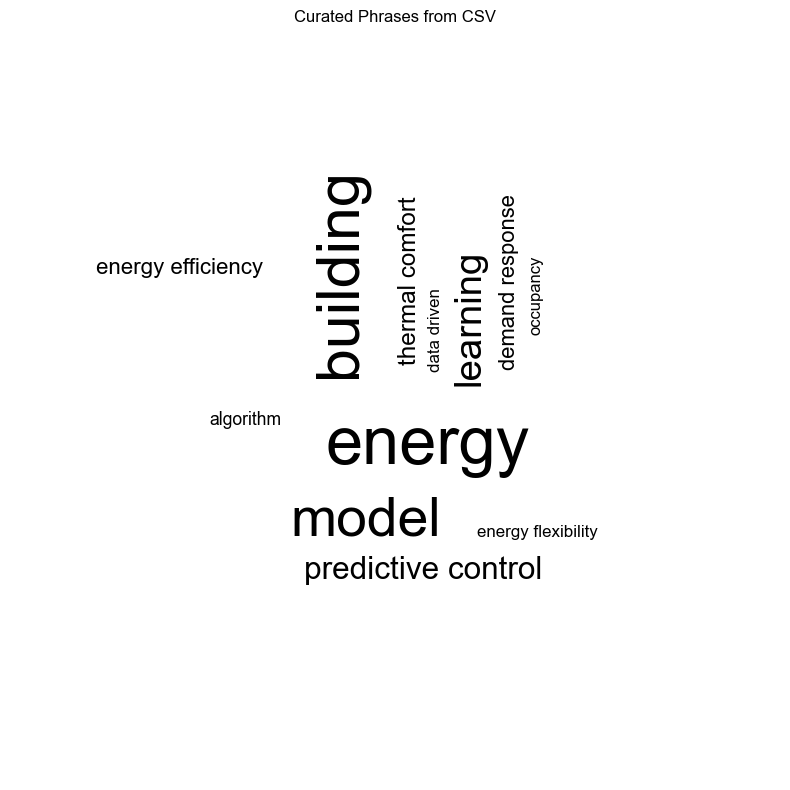

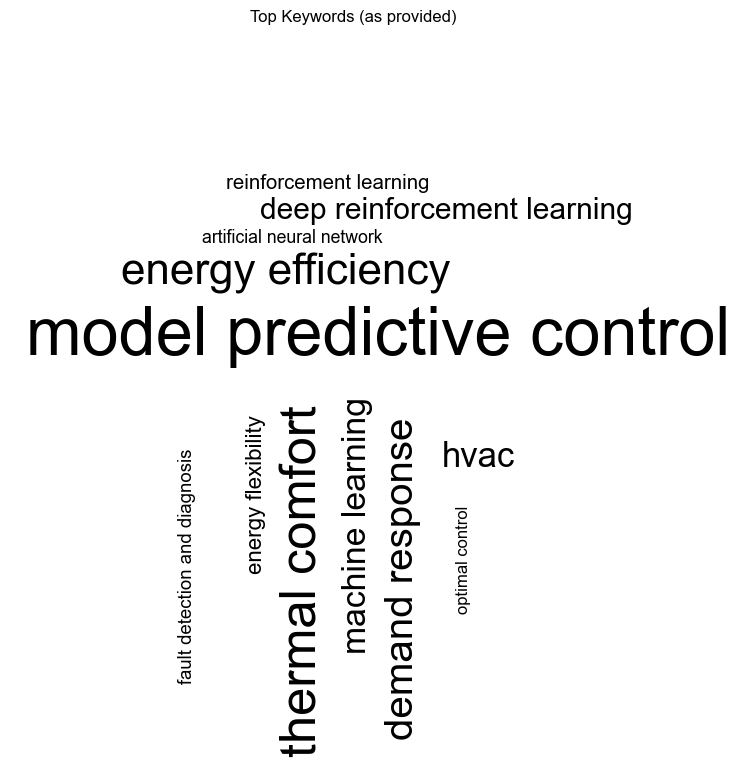

In [16]:
import os, re, random, unicodedata, json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib

matplotlib.rcParams['font.family'] = 'Arial'
random.seed(11)

# ------------ paths ------------
DOWNLOAD_DIR = 'papers_json'  # Directory containing JSON files
KEYWORDS_CSV = "csv/_keywords.csv"
TOP_N = 12  # show more terms

# ------------ helpers ------------
def normalize_text(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s))
    s = s.replace("artifitial", "artificial")
    return (s.replace("\ufb01","fi").replace("\ufb02","fl")
             .replace("–","-").replace("—","-"))

def phrase_to_regex(phrase: str):
    # Flexible match allowing hyphen/space variations & suffixes
    parts = [re.escape(t) + r"\w*" for t in re.split(r"[-\s]+", phrase.strip()) if t]
    if not parts: return None
    return re.compile(r"(?:%s)" % r"[-\s]*".join(parts), re.IGNORECASE)

def split_terms(s: str):
    """Split author-supplied keywords when they are lumped into a single field."""
    if pd.isna(s): return []
    # split on comma, semicolon, or pipe
    return [x.strip() for x in re.split(r"[;,|]", str(s)) if x.strip()]

def strip_parens(s: str):
    # remove parenthetical mentions like "(review)" or "(DSM)"
    return re.sub(r'\s*\([^)]*\)', '', s).strip()

def clean_keyword_phrase(s: str):
    """Light cleaning but keep the phrase intact."""
    s = normalize_text(s)
    s = strip_parens(s)
    # collapse internal whitespace & stray hyphen spacing
    s = re.sub(r"\s+", " ", s)
    s = s.strip()
    return s

def draw_tag(items, title):
    if not items:
        print(title + ": no phrases to display."); return

    # --- size scaling: compress range a bit to reduce crowding ---
    vals = [v for _, v in items]; vmin, vmax = min(vals), max(vals)
    fmin, fmax = 12, 48
    def scale(v): return fmin + (v - vmin) * (fmax - fmin) / (vmax - vmin) if vmax != vmin else 28

    import numpy as np
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis("off"); ax.set_title(title)

    MAX_ITERS = 8000
    PAD_X, PAD_Y = 1, 1
    MARG_X, MARG_Y = 0.06, 0.08
    R_BASE, R_GAIN = 0.010, 0.0007
    JITTER = 0.12
    ROTATIONS = [0, 90]

    fig.canvas.draw(); renderer = fig.canvas.get_renderer()
    placed = []

    items_sorted = sorted(items, key=lambda kv: kv[1], reverse=True)

    def try_place(txt):
        theta = 0.0; r = R_BASE
        cx, cy = 0.5, 0.5
        golden = 0.5*(3-np.sqrt(5)) * 2*np.pi
        for _ in range(MAX_ITERS):
            theta += golden
            r += R_GAIN
            x = cx + r*np.cos(theta) + np.random.uniform(-JITTER, JITTER)
            y = cy + r*np.sin(theta) + np.random.uniform(-JITTER, JITTER)
            if x < MARG_X or x > 1-MARG_X or y < MARG_Y or y > 1-MARG_Y:
                continue
            txt.set_position((x, y))
            bbox = txt.get_window_extent(renderer=renderer).expanded(PAD_X, PAD_Y)
            if not any(bbox.overlaps(b) for b in placed):
                placed.append(bbox)
                return True
        return False

    for i, (phrase, cnt) in enumerate(items_sorted):
        fs_target = scale(cnt)
        rotation = ROTATIONS[i % len(ROTATIONS)]
        for shrink in (1.0, 0.95, 0.9, 0.85, 0.8, 0.75):
            txt = ax.text(0.5, 0.5, phrase,
                          fontsize=fs_target*shrink,
                          rotation=rotation,
                          ha="center", va="center",
                          fontname="Arial")
            if try_place(txt):
                break
            txt.remove()

    plt.tight_layout(); plt.show()

# ------------ data ingest ------------
def extract_keywords_from_json(folder_path):
    """
    Extract keywords as phrases from JSON files, splitting on commas/semicolons
    when authors lump multiple keywords into a single string. Keep phrases intact.
    """
    all_keywords_raw = []   # keep an original for display if you want
    all_keywords_clean = [] # normalized for counting

    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        keywords_data = (
            data.get('full-text-retrieval-response', {})
                .get('coredata', {})
                .get('dcterms:subject', [])
        )

        # Scopus-like export: each item usually has its own '$'
        for kw in keywords_data:
            if '$' not in kw:
                continue
            raw_field = kw['$']
            # split a field like "demand response; model predictive control"
            for phrase in split_terms(raw_field):
                clean = clean_keyword_phrase(phrase)
                if not clean:
                    continue
                all_keywords_raw.append(phrase)
                all_keywords_clean.append(clean.lower())  # count in lowercase

    return all_keywords_raw, all_keywords_clean

# ------------ main execution ------------
print(f"Extracting keywords from JSON files in {DOWNLOAD_DIR}...")
raw_keywords, keywords_norm = extract_keywords_from_json(DOWNLOAD_DIR)
print(f"Found {len(keywords_norm)} keyword phrases")

# Build a DataFrame (optional, for compatibility with your curated matching)
df_keywords = pd.DataFrame({
    # store the cleaned form for matching/regex; keep a raw column if you like
    'Keyword': [normalize_text(k) for k in keywords_norm],
    'Year': [2023] * len(keywords_norm)  # adjust if you have year data
})

titles = df_keywords['Keyword'].astype(str)

# ===== Plot A: Curated phrases (original terms; drop loc_post variants) =====
curated_counts = []
curated_terms_clean = []
if os.path.exists(KEYWORDS_CSV):
    kw = pd.read_csv(KEYWORDS_CSV)
    cmap = {c.lower(): c for c in kw.columns}
    cat_col, keys_col, ref_col = cmap.get("category"), cmap.get("keywords"), cmap.get("ref")
    if cat_col and keys_col:
        raw_terms = []
        for _, r in kw.iterrows():
            raw_terms += split_terms(r[keys_col])
            if ref_col and pd.notna(r[ref_col]): raw_terms += split_terms(r[ref_col])

        # remove placeholders: loc_post variants and underscores
        BAD_LOC = re.compile(r"\bloc[_\-\s]?(post|pre)\b", re.I)
        for term in raw_terms:
            t = term.strip()
            if not t: continue
            tflat = t.lower().replace("_"," ").replace("-"," ").strip()
            if "_" in t or BAD_LOC.search(t) or tflat in {"loc post","post loc"}:
                continue
            curated_terms_clean.append(t)

        # count with flexible regex (original terms as shown)
        for t in curated_terms_clean:
            rx = phrase_to_regex(t)
            if rx is None: continue
            hits = int(titles.str.contains(rx, na=False).sum())
            if hits > 0: curated_counts.append((t, hits))

curated_counts.sort(key=lambda x: x[1], reverse=True)
draw_tag(curated_counts[:TOP_N], "Curated Phrases from CSV")

# ===== Plot B: Top Keywords (as provided in JSON) =====
# Count exact phrases (case-insensitive) but display in a nice title case
counts = Counter(keywords_norm)

# Optional: unify display casing by choosing the most common raw variant per normalized key
# Build a map from normalized -> most frequent display string
display_map = {}
raw_counter = Counter([normalize_text(clean_keyword_phrase(r)).lower() for r in raw_keywords])
for norm_key in counts:
    # pick the most common raw spelling that normalizes to this norm_key
    # fall back to the norm_key itself
    candidates = [r for r in raw_counter if r == norm_key]
    if candidates:
        best = max(candidates, key=lambda c: raw_counter[c])
        display_map[norm_key] = best
    else:
        display_map[norm_key] = norm_key

top_keyword_items = [(display_map[k], v) for k, v in counts.most_common(TOP_N)]
draw_tag(top_keyword_items, "Top Keywords (as provided)")
